In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv
/kaggle/input/dogs-vs-cats/test1.zip


# Dog and Cat Calssification - Accuracy - 54%

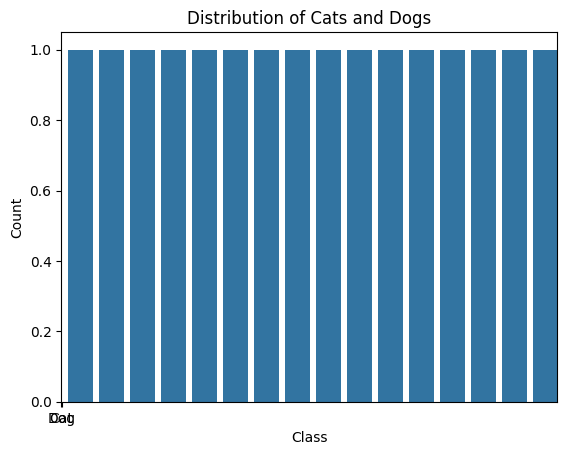

Accuracy: 54.00%
              precision    recall  f1-score   support

         Cat       0.53      0.61      0.57       197
         Dog       0.56      0.47      0.51       203

    accuracy                           0.54       400
   macro avg       0.54      0.54      0.54       400
weighted avg       0.54      0.54      0.54       400



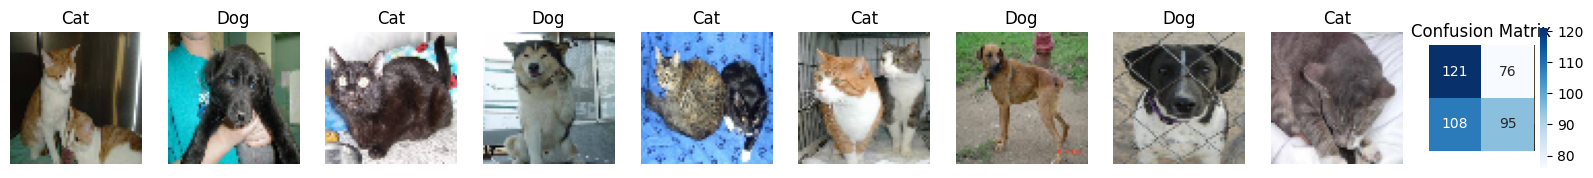

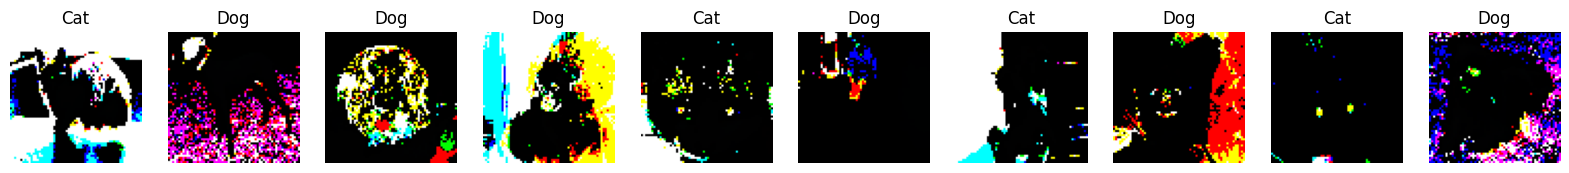

In [ ]:
import os
import zipfile
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Unzip the dataset files
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/train')

with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/test')

# Define paths to the dataset
TRAIN_DIR = '/kaggle/working/train/train'
TEST_DIR = '/kaggle/working/test/test1'

# Function to load images and their labels
def load_images_labels(directory, limit=None):
    images = []
    labels = []
    for idx, filename in enumerate(os.listdir(directory)):
        if limit and idx >= limit:
            break
        label = 1 if 'dog' in filename else 0
        img_path = os.path.join(directory, filename)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (64, 64))  # Resize to a smaller size for faster processing
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

# Load training data
X, y = load_images_labels(TRAIN_DIR, limit=2000)  # Limit to 2000 images for faster processing

# EDA: Visualize the distribution of classes
sns.countplot(y)
plt.title('Distribution of Cats and Dogs')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Cat', 'Dog'])
plt.show()

# Show some sample images
def plot_samples(images, labels, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        # Convert to uint8 before displaying
        img = images[i].astype('uint8')
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title("Dog" if labels[i] == 1 else "Cat")
        plt.axis("off")

plot_samples(X, y, n=10)

# Flatten images for SVM
X_flattened = X.reshape(X.shape[0], -1)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train SVM classifier
svm = SVC(kernel='linear', C=1.0, random_state=42)
svm.fit(X_train, y_train)

# Predict and evaluate
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')
print(classification_report(y_test, y_pred, target_names=['Cat', 'Dog']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Visualize some predictions
plot_samples(X_test.reshape(-1, 64, 64, 3)[:10], y_test[:10], n=10)
plt.show()


# Improve the Accuracy Using CNN (Accuracy : 71%)

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'dogs-vs-cats:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3362%2F31148%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240805%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240805T083316Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D629e0962601e20c752e584d7bb17cb2a355b8ddda7dc545d2885e93268c70ba7e259963a06daa4a8bca9ed641d3c21cf13e294b02fbd80cd95ffbb661f284add5e6f2aafd87f9cea98230fc9e4bf660570282fed762390d4302c5bff5da37a4b621a0993f5cfa1dced1f378baabf44a6f45e6091effe599a5a81372c816750a941e25c070b836ad03bd90247cb49be486a76678c4c2a6b9f2e549184b6a1a6ab1eb6a957e6b88099eb3a677f516f346e2428e2ba6fb6070b742fb5adb99d3be50a329bbe4fc764abfbe47117003ff5827cbca370df7e4c7b070242a557d4feabd998fc039cfeb213ad535161be779b5f185edb12148905b7336b7006fa532fd5'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 851576689 bytes downloaded
Downloaded and uncompressed: dogs-vs-cats
Data source import complete.


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 260ms/step - accuracy: 0.5194 - loss: 0.7497 - val_accuracy: 0.5275 - val_loss: 0.6899
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 255ms/step - accuracy: 0.5294 - loss: 0.6881 - val_accuracy: 0.5100 - val_loss: 0.6904
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 278ms/step - accuracy: 0.5602 - loss: 0.6741 - val_accuracy: 0.5500 - val_loss: 0.6652
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 245ms/step - accuracy: 0.6193 - loss: 0.6475 - val_accuracy: 0.6175 - val_loss: 0.6418
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 242ms/step - accuracy: 0.6871 - loss: 0.6033 - val_accuracy: 0.6450 - val_loss: 0.6290
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 243ms/step - accuracy: 0.7438 - loss: 0.5361 - val_accuracy: 0.6675 - val_loss: 0.6120
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 242ms/step - accuracy: 0.7529 - loss: 0.5108 - val_accuracy: 0.6525 - val_loss: 0.6379
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 228ms/step - accuracy: 0.7922 - loss: 0.4587 - val_accu

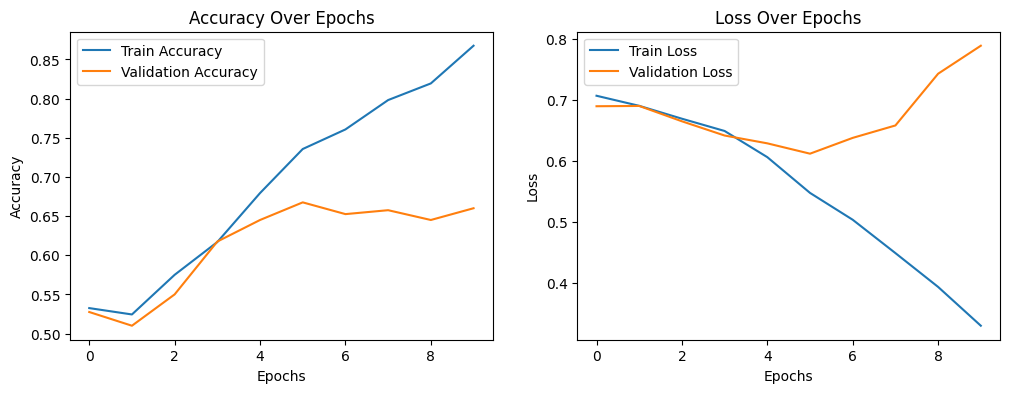

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
              precision    recall  f1-score   support

         Cat       0.76      0.46      0.57       197
         Dog       0.62      0.86      0.72       203

    accuracy                           0.66       400
   macro avg       0.69      0.66      0.64       400
weighted avg       0.69      0.66      0.65       400



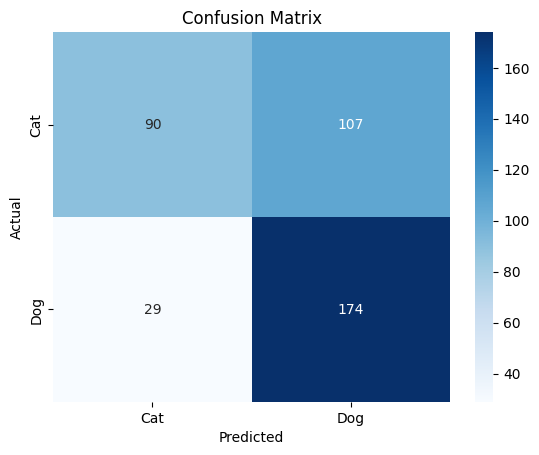

In [ ]:
import os
import zipfile
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Unzip the dataset files
with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/train')

with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/test1.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/test')

# Define paths to the dataset
TRAIN_DIR = '/kaggle/working/train/train'
TEST_DIR = '/kaggle/working/test/test1'

# Function to load images and their labels
def load_images_labels(directory, limit=None):
    images = []
    labels = []
    for idx, filename in enumerate(os.listdir(directory)):
        if limit and idx >= limit:
            break
        label = 1 if 'dog' in filename else 0
        img_path = os.path.join(directory, filename)
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (64, 64))  # Resize to a smaller size for faster processing
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)

# Load training data
X, y = load_images_labels(TRAIN_DIR, limit=2000)  # Limit to 2000 images for faster processing

# Normalize the images
X = X / 255.0

# Convert labels to categorical
y = to_categorical(y, 2)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Plot accuracy and loss over epochs
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.show()

# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=['Cat', 'Dog']))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
